In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 14})

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def running_avg(x):
    return np.cumsum(x) / np.arange(1, x.size + 1)

def running_timeavg(t,x):
    dt = t[1:] - t[:-1]
    x = np.cumsum(x[:-1] * dt)
    y = t[1:]
    return [a/b for a,b in zip(x,y)]

def filter_vec(df, name):
    x = df[(df.name == name + ":vector") & (df.type == "vector")] #.filter(["vectime","vecvalue"])
    return x #pd.DataFrame(index=x.vectime.values[0], data={name : x.vecvalue.values[0]})
    
#for i in range(1,len(vec)):
#    row = vec.iloc[i]
#    row = pd.DataFrame(index=row.vectime, data={data_name : row.vecvalue})
#    mean_res = pd.concat((mean_res, row)    
#mean_res = mean_res_dc.groupby(level=0).mean()

/home/ulysses/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Caso DC - Recursos

In [2]:
# Cargamos los datos
targetDcRes = pd.read_csv("targetDcRes.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetDcRes[targetDcRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,vectime,vecvalue
84,targetDc-0-20250720-18:42:17-38680,vector,MediumNet.dc.resourceManager,allocatedRam:vector,NaN,None,"[1.227014982681, 1.23463926123, 1.23463948651,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
89,targetDc-0-20250720-18:42:17-38680,vector,MediumNet.dc.resourceManager,allocatedDisk:vector,NaN,None,"[1.227014982681, 1.23463926123, 1.23463948651,...","[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250..."
94,targetDc-0-20250720-18:42:17-38680,vector,MediumNet.dc.resourceManager,allocatedCores:vector,NaN,None,"[1.227014982681, 1.23463926123, 1.23463948651,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
98,targetDc-0-20250720-18:42:17-38680,vector,MediumNet.dc.resourceManager,allocatedVms:vector,NaN,None,"[1.227014982681, 1.23463926123, 1.23463948651,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [3]:
def process_vector(df, data_name: str):
    # Empezamos el proceso de merging del conjunto de datos
    row = df.iloc[0]
    print(type(row.vectime))
    print(type(row.vecvalue))
    
    times = np.append([0], row.vectime)
    times = np.append(times, [3600])
    
    # Accumulate the values
    values = np.cumsum(row.vecvalue)
    values = np.append([0], values)
    values = np.append(values, max(values))
    
    vec = pd.DataFrame(index=times, data={data_name : values})
    
    return vec

In [4]:
res_dc = dict()
res_dc["vms"] = process_vector(filter_vec(targetDcRes, "allocatedVms"), "vms")
res_dc["ram"] = process_vector(filter_vec(targetDcRes, "allocatedRam"), "ram")
res_dc["disk"] = process_vector(filter_vec(targetDcRes, "allocatedDisk"), "disk")
res_dc["cpus"] = process_vector(filter_vec(targetDcRes, "allocatedCores"), "cpus")
res_dc["vms"]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


,vms
0.000000,0.0
1.227015,1.0
1.234639,2.0
1.234639,3.0
1.238264,4.0
1.241700,5.0
1.241700,6.0
1.241700,7.0
1.245488,8.0
1.245488,9.0


## Gráficas

In [5]:
dc_num_blades = 40
dc_max_vms = dc_num_blades*16
dc_max_ram = dc_num_blades*64
dc_max_disk = dc_num_blades*4000
dc_max_cpus = dc_num_blades*16

In [6]:
def plot_under_curve(axis, x, y ,color):
    axis.plot(x,y, color=color)
    axis.fill_between(x,y.reshape(-1),0, color=color, alpha=.1)

In [7]:
def plot_box(title,axis_title, x, y, color):
    fig, ax = plt.subplots(figsize=(4,3))
    plt.tight_layout()
    plot_under_curve(ax, x, y, color)
    ax.set(ylabel=axis_title)
    ax.set(xlabel='Simulation time (s)')
    ax.set_ylim(0,100)
    ax.set_xlim(0,3600)
    fig.savefig(title, bbox_inches='tight')

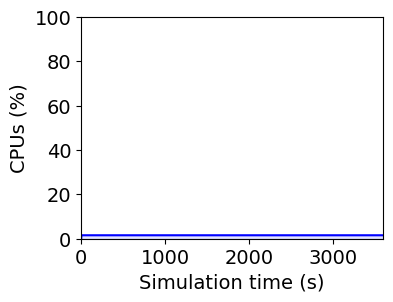

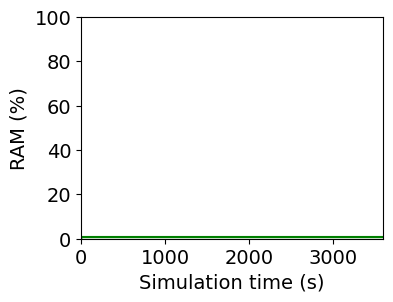

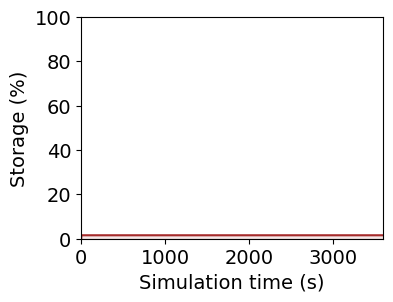

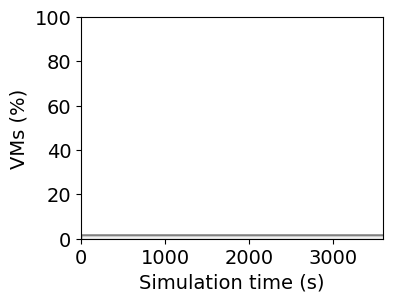

In [8]:
plot_box("mediumResDcCpu.pdf", 'CPUs (%)', res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_cpus) * 100, "blue")
plot_box("mediumResDcRam.pdf", 'RAM (%)', res_dc["ram"].index, (res_dc["ram"].values / dc_max_ram) * 100, "green")
plot_box("mediumResDcDisk.pdf", 'Storage (%)', res_dc["disk"].index, (res_dc["disk"].values / dc_max_disk) * 100, "brown")
plot_box("mediumResDcVms.pdf", 'VMs (%)', res_dc["vms"].index, (res_dc["vms"].values / dc_max_vms) * 100, "gray")

## Caso Fog - Recursos

In [9]:
# Cargamos los datos
targetFogRes = pd.read_csv("targetFogRes.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetFogRes[targetFogRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,vectime,vecvalue
84,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg1.resourceManager,allocatedRam:vector,NaN,None,"[1.287015329961, 1.429043584261, 1.429043584261]","[2.0, 2.0, 2.0]"
89,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg1.resourceManager,allocatedDisk:vector,NaN,None,"[1.287015329961, 1.429043584261, 1.429043584261]","[250.0, 250.0, 250.0]"
94,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg1.resourceManager,allocatedCores:vector,NaN,None,"[1.287015329961, 1.429043584261, 1.429043584261]","[1.0, 1.0, 1.0]"
98,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg1.resourceManager,allocatedVms:vector,NaN,None,"[1.287015329961, 1.429043584261, 1.429043584261]","[1.0, 1.0, 1.0]"
102,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg2.resourceManager,allocatedRam:vector,NaN,None,"[1.300845264117, 4.136517016198, 4.391475521486]","[2.0, 2.0, 2.0]"
107,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg2.resourceManager,allocatedDisk:vector,NaN,None,"[1.300845264117, 4.136517016198, 4.391475521486]","[250.0, 250.0, 250.0]"
112,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg2.resourceManager,allocatedCores:vector,NaN,None,"[1.300845264117, 4.136517016198, 4.391475521486]","[1.0, 1.0, 1.0]"
116,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg2.resourceManager,allocatedVms:vector,NaN,None,"[1.300845264117, 4.136517016198, 4.391475521486]","[1.0, 1.0, 1.0]"
120,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg3.resourceManager,allocatedRam:vector,NaN,None,"[1.300845342517, 1.429043848261]","[2.0, 2.0]"
125,targetFog-0-20250720-18:39:48-38382,vector,MediumNet.fg3.resourceManager,allocatedDisk:vector,NaN,None,"[1.300845342517, 1.429043848261]","[250.0, 250.0]"


In [10]:
def process_vector2(df, data_name: str):
    vecs = []
    # Empezamos el proceso de merging del conjunto de datos
    ordered = df.sort_values(["module"])
    for i in range(0,len(df)):
        row = ordered.iloc[i]
    
        times = np.append([0], row.vectime)
        times = np.append(times, [3600])
    
        # Accumulate the values
        values = np.cumsum(row.vecvalue)
        values = np.append([0], values)
        values = np.append(values, max(values))
    
        vecs.append(pd.DataFrame(index=times, data={data_name : values}))
    
    return vecs

In [11]:
res_fog = dict()
res_fog["vms"] = process_vector2(filter_vec(targetFogRes, "allocatedVms"), "vms")
res_fog["ram"] = process_vector2(filter_vec(targetFogRes, "allocatedRam"), "ram")
res_fog["disk"] = process_vector2(filter_vec(targetFogRes, "allocatedDisk"), "disk")
res_fog["cpus"] = process_vector2(filter_vec(targetFogRes, "allocatedCores"), "cpus")
res_fog["vms"]

[             vms
 0.000000     0.0
 1.287015     1.0
 1.429044     2.0
 1.429044     3.0
 3600.000000  3.0,
              vms
 0.000000     0.0
 1.300845     1.0
 4.136517     2.0
 4.391476     3.0
 3600.000000  3.0,
              vms
 0.000000     0.0
 1.300845     1.0
 1.429044     2.0
 3600.000000  2.0,
              vms
 0.000000     0.0
 1.307327     1.0
 1.432355     2.0
 3600.000000  2.0]

## Gráficas

In [12]:
n_fog = 1
fog_max_vms = n_fog * 8
fog_max_ram = n_fog * 16
fog_max_disk = n_fog * 2000
fog_max_cpus = n_fog * 8

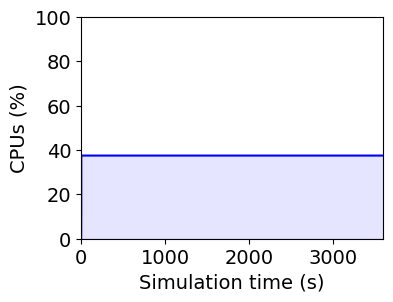

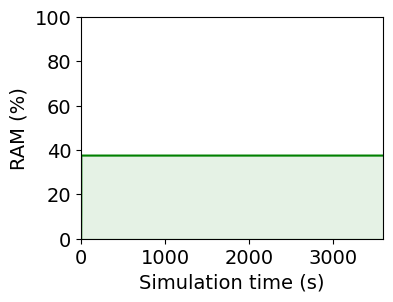

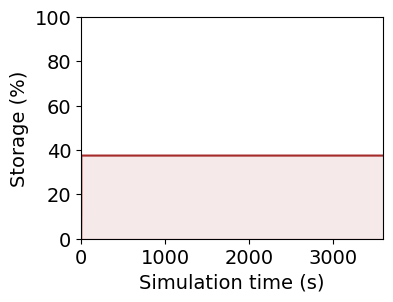

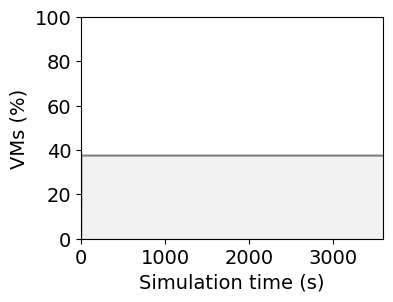

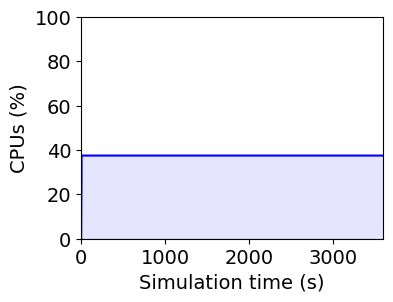

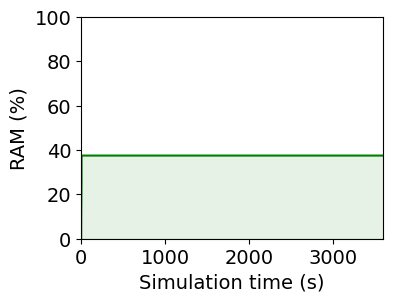

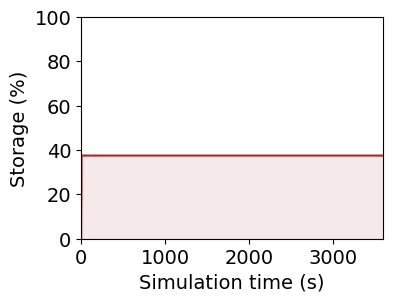

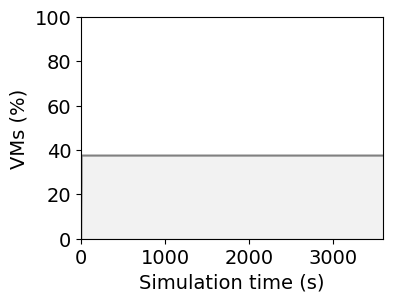

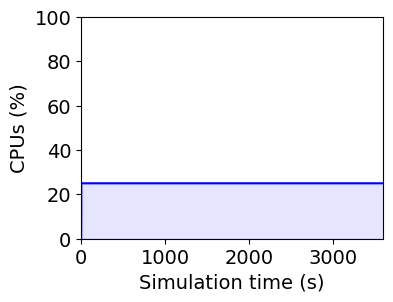

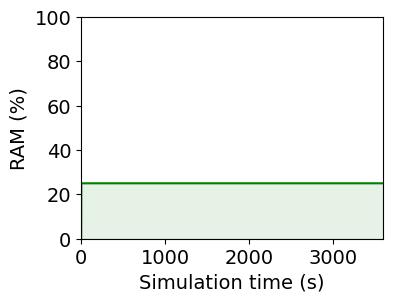

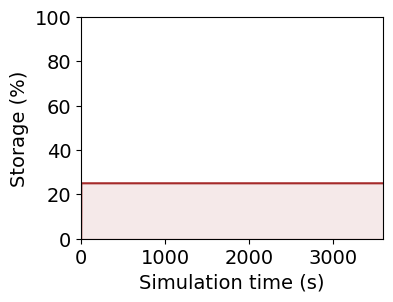

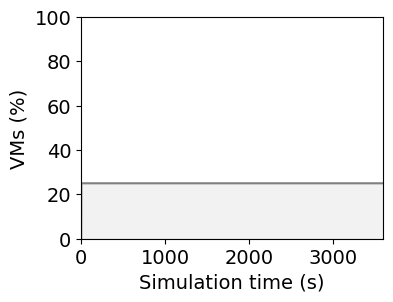

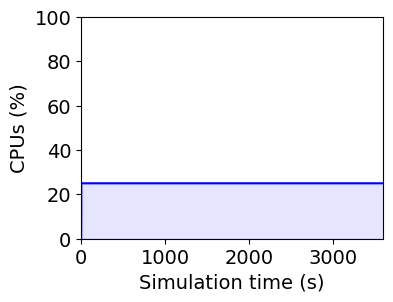

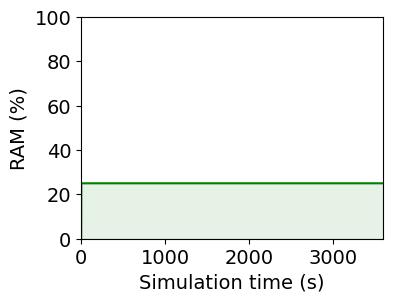

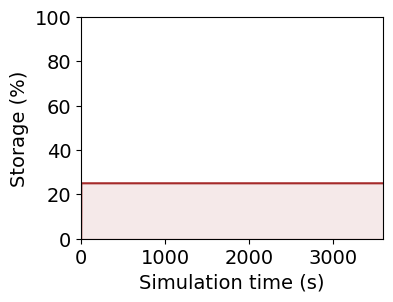

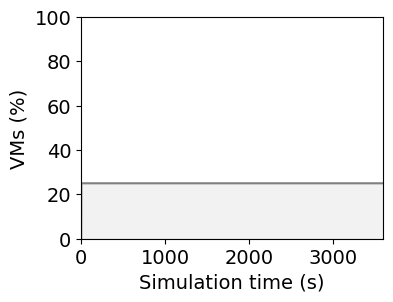

In [13]:
for i in range(4):
    plot_box(f"mediumResFog{i}Cpu.pdf", 'CPUs (%)', res_fog["cpus"][i].index, (res_fog["cpus"][i].values / fog_max_cpus) * 100, "blue")
    plot_box(f"mediumResFog{i}Ram.pdf", 'RAM (%)', res_fog["ram"][i].index, (res_fog["ram"][i].values / fog_max_ram) * 100, "green")
    plot_box(f"mediumResFog{i}Disk.pdf", 'Storage (%)', res_fog["disk"][i].index, (res_fog["disk"][i].values / fog_max_disk) * 100, "brown")
    plot_box(f"mediumResFog{i}Vms.pdf", 'VMs (%)', res_fog["vms"][i].index, (res_fog["vms"][i].values / fog_max_vms) * 100, "gray")